
**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 624kB 4.8MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-6.0.0.post0-cp36-cp36m-linux_x86_64.whl size=1062836 sha256=bd9225ef558df4eb016cee1470965e8cf16f8ca487f0039bbae31d5d1378e619
  Stored in directory: /root/.cache/pip/wheels/06/60/65/cc9afa345ccbf10a34cc208266b992941a8608010b592f43d1
Successfully built Pillow-SIMD


**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

import numpy as np
import copy

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from google.colab import files


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default        # Coef for discriminator reverse gradient

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 8       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Define DNN

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Function
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class DANN(nn.Module):

    def __init__(self, num_classes=1000):
        super(DANN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.classifier_domain = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2), # classifier between domain source or target
        )

    def forward(self, x, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if alpha is not None:
          x = ReverseLayerF.apply(x, alpha)
          x = self.classifier_domain(x)
        else:
          x = self.classifier(x)
        return x


def dann( **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
  
    model = DANN(**kwargs)
    #state_dict = load_state_dict_from_url(model_urls['alexnet'],
    #                                      progress=True)
    model.load_state_dict(torch.load("alexnet-owt-4df8aa71.pth"), strict=False)
    for i in [1,4]:
      model.classifier_domain[i].weight.data = model.classifier[i].weight.data
      model.classifier_domain[i].bias.data = model.classifier[i].bias.data
    model.classifier[6] = nn.Linear(4096, 7)
    return model

# Utility Function

In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import numpy as np

def heatmap(datas, row_labels, col_labels,  ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    #print(datas)
    im = ax.imshow(datas)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(datas.shape[1]))
    ax.set_yticks(np.arange(datas.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(row_labels)
    ax.set_yticklabels(col_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(datas.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(datas.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt ="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.
    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS
  !wget https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
  
PHOTO_DIR = 'Homework3-PACS/PACS/photo'
ART_DIR = 'Homework3-PACS/PACS/art_painting'
CAR_DIR = 'Homework3-PACS/PACS/cartoon'
SKT_DIR = 'Homework3-PACS/PACS/sketch'
# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(PHOTO_DIR, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(ART_DIR, transform=eval_transform)
car_dataset = torchvision.datasets.ImageFolder(CAR_DIR, transform=eval_transform)
skt_dataset = torchvision.datasets.ImageFolder(SKT_DIR, transform=eval_transform)
# Check dataset sizes
print('Train Dataset: {}'.format(len(photo_dataset)))
print('Test Dataset: {}'.format(len(art_dataset)))
print('Train Dataset: {}'.format(len(car_dataset)))
print('Test Dataset: {}'.format(len(skt_dataset)))

Train Dataset: 1670
Test Dataset: 2048
Train Dataset: 2344
Test Dataset: 3929


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
car_dataloader = DataLoader(car_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,drop_last=False)
skt_dataloader = DataLoader(skt_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
print('Train Dataset: {}'.format(len(photo_dataloader)*BATCH_SIZE))
print('Test Dataset: {}'.format(len(art_dataloader)*BATCH_SIZE))

Train Dataset: 1536
Test Dataset: 2048


**Prepare Training**

In [0]:
# Define loss function
criterion_classifier = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
criterion_domain = nn.CrossEntropyLoss()
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
 # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum


# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs


**Train**

Starting epoch 1/10, LR = [0.01], ALPHA = 0.005
Step 0, Loss Net 2.185908555984497
Step 0, Loss Discriminator Class Label0 1.1421525478363037
Step 0, Loss Discriminator Class Label1 0.39558279514312744




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.90s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.82s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.36it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.95s/it]

 30%|███       | 3/10 [00:04<00:15,  2.17s/it]



Validation Accuracy on Sketch/Car: 0.2561772676550295

Starting epoch 2/10, LR = [0.01], ALPHA = 0.005
Step 10, Loss Net 0.1701350212097168
Step 10, Loss Discriminator Class Label0 0.6770986914634705
Step 10, Loss Discriminator Class Label1 0.07700596004724503




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.94s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.85s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.09s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.39s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.17it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.44it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.17s/it]

 20%|██        | 2/10 [00:04<00:24,  3.02s/it]

 30%|███       | 3/10 [00:04<00:15,  2.20s/it]



Validation Accuracy on Sketch/Car: 0.291567033317392

Starting epoch 3/10, LR = [0.01], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.91s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.82s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.93s/it]

 20%|██        | 2/10 [00:04<00:22,  2.85s/it]

 30%|███       | 3/10 [00:04<00:14,  2.08s/it]



Validation Accuracy on Sketch/Car: 0.2518731069663638

Starting epoch 4/10, LR = [0.01], ALPHA = 0.005
Step 20, Loss Net 0.04263908416032791
Step 20, Loss Discriminator Class Label0 0.10933537036180496
Step 20, Loss Discriminator Class Label1 0.11536802351474762




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:01,  4.13s/it]

 12%|█▎        | 2/16 [00:04<00:41,  3.00s/it]

 19%|█▉        | 3/16 [00:04<00:28,  2.19s/it]

 25%|██▌       | 4/16 [00:05<00:19,  1.63s/it]

 31%|███▏      | 5/16 [00:07<00:21,  1.94s/it]

 38%|███▊      | 6/16 [00:08<00:14,  1.46s/it]

 44%|████▍     | 7/16 [00:08<00:10,  1.12s/it]

 50%|█████     | 8/16 [00:08<00:07,  1.14it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.04it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.37it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.78it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.03s/it]

 20%|██        | 2/10 [00:04<00:23,  2.92s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.23146819703491153

Starting epoch 5/10, LR = [0.01], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.93s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.86s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.11s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.79s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.34s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.02s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.24it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.06s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.25it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.63it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.94s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.26669854933843457

Starting epoch 6/10, LR = [0.01], ALPHA = 0.005
Step 30, Loss Net 0.017157068476080894
Step 30, Loss Discriminator Class Label0 0.07080256193876266
Step 30, Loss Discriminator Class Label1 0.07750865817070007




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.96s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.87s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.11s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.58s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.51it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.36it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.91s/it]

 20%|██        | 2/10 [00:04<00:22,  2.87s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.29523354057069984

Starting epoch 7/10, LR = [0.01], ALPHA = 0.005
Step 40, Loss Net 0.009914839640259743
Step 40, Loss Discriminator Class Label0 0.11989665776491165
Step 40, Loss Discriminator Class Label1 0.021013563498854637




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.86s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.85s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.33it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:39,  4.35s/it]

 20%|██        | 2/10 [00:04<00:25,  3.15s/it]

 30%|███       | 3/10 [00:05<00:16,  2.31s/it]



Validation Accuracy on Sketch/Car: 0.31739199744938623

Starting epoch 8/10, LR = [0.01], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:55,  3.71s/it]

 12%|█▎        | 2/16 [00:04<00:37,  2.71s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.00s/it]

 25%|██▌       | 4/16 [00:04<00:17,  1.49s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.75s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:10<00:08,  1.23s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.08s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.24it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.61it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:38,  4.24s/it]

 20%|██        | 2/10 [00:04<00:24,  3.06s/it]

 30%|███       | 3/10 [00:04<00:15,  2.25s/it]



Validation Accuracy on Sketch/Car: 0.3194643711142994

Starting epoch 9/10, LR = [0.001], ALPHA = 0.005
Step 50, Loss Net 0.005074311047792435
Step 50, Loss Discriminator Class Label0 0.024197380989789963
Step 50, Loss Discriminator Class Label1 0.0450030155479908




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.97s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.86s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.11s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.69it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.02s/it]

 20%|██        | 2/10 [00:04<00:23,  2.92s/it]

 30%|███       | 3/10 [00:04<00:14,  2.14s/it]



Validation Accuracy on Sketch/Car: 0.31850789096126253

Starting epoch 10/10, LR = [0.001], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:55,  3.71s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.76s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.02s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.79s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.06s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.26it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.64it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.01s/it]

 20%|██        | 2/10 [00:04<00:23,  2.91s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.31802965088474416

Starting epoch 1/10, LR = [0.001], ALPHA = 0.005
Step 0, Loss Net 2.266988754272461
Step 0, Loss Discriminator Class Label0 0.8667221069335938
Step 0, Loss Discriminator Class Label1 0.9595706462860107




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.76s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.18it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.45it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.03s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.28it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.67it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:39,  4.37s/it]

 20%|██        | 2/10 [00:04<00:25,  3.16s/it]

 30%|███       | 3/10 [00:05<00:16,  2.32s/it]



Validation Accuracy on Sketch/Car: 0.23130878367607205

Starting epoch 2/10, LR = [0.001], ALPHA = 0.005
Step 10, Loss Net 0.33371108770370483
Step 10, Loss Discriminator Class Label0 0.19542527198791504
Step 10, Loss Discriminator Class Label1 0.23595282435417175




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.95s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.87s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.12s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.51it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.04s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.28it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.67it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.03s/it]

 20%|██        | 2/10 [00:04<00:23,  2.94s/it]

 30%|███       | 3/10 [00:04<00:15,  2.15s/it]



Validation Accuracy on Sketch/Car: 0.27817631117487646

Starting epoch 3/10, LR = [0.001], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:00,  4.03s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.92s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.13s/it]

 25%|██▌       | 4/16 [00:04<00:19,  1.59s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.89s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:10,  1.43s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.09s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.17it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.44it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.71it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.11s/it]

 20%|██        | 2/10 [00:04<00:23,  2.98s/it]

 30%|███       | 3/10 [00:04<00:15,  2.20s/it]



Validation Accuracy on Sketch/Car: 0.2604814283436952

Starting epoch 4/10, LR = [0.001], ALPHA = 0.005
Step 20, Loss Net 0.113233283162117
Step 20, Loss Discriminator Class Label0 0.22608888149261475
Step 20, Loss Discriminator Class Label1 0.14052842557430267




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.95s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.86s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.10s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.90s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:11<00:10,  1.44s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.11s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.16it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.06s/it]

 20%|██        | 2/10 [00:04<00:23,  2.94s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.2537860672724374

Starting epoch 5/10, LR = [0.001], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.91s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.85s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.08s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.85s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.39s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:14<00:01,  1.24it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.62it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.04s/it]

 20%|██        | 2/10 [00:04<00:23,  2.92s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.23577235772357724

Starting epoch 6/10, LR = [0.001], ALPHA = 0.005
Step 30, Loss Net 0.11287356168031693
Step 30, Loss Discriminator Class Label0 0.14122022688388824
Step 30, Loss Discriminator Class Label1 0.08894488960504532




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.94s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.85s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.10s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.38s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.06it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.11s/it]

 20%|██        | 2/10 [00:04<00:23,  2.98s/it]

 30%|███       | 3/10 [00:04<00:15,  2.19s/it]



Validation Accuracy on Sketch/Car: 0.22046867527498804

Starting epoch 7/10, LR = [0.001], ALPHA = 0.005
Step 40, Loss Net 0.07242260873317719
Step 40, Loss Discriminator Class Label0 0.12210562080144882
Step 40, Loss Discriminator Class Label1 0.1192973181605339




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.96s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.88s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.11s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.58s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.90s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.44s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.10s/it]

 50%|█████     | 8/16 [00:08<00:07,  1.13it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:38,  4.28s/it]

 20%|██        | 2/10 [00:04<00:24,  3.10s/it]

 30%|███       | 3/10 [00:04<00:15,  2.27s/it]



Validation Accuracy on Sketch/Car: 0.21600510122748287

Starting epoch 8/10, LR = [0.001], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.43it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.96s/it]

 20%|██        | 2/10 [00:04<00:23,  2.88s/it]

 30%|███       | 3/10 [00:04<00:14,  2.11s/it]



Validation Accuracy on Sketch/Car: 0.22955523672883787

Starting epoch 9/10, LR = [0.0001], ALPHA = 0.005
Step 50, Loss Net 0.052083343267440796
Step 50, Loss Discriminator Class Label0 0.09048554301261902
Step 50, Loss Discriminator Class Label1 0.08853515982627869




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:54,  3.65s/it]

 12%|█▎        | 2/16 [00:04<00:37,  2.70s/it]

 19%|█▉        | 3/16 [00:04<00:25,  1.99s/it]

 25%|██▌       | 4/16 [00:04<00:17,  1.49s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.76s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.37s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:08,  1.28s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.51it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.09s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.23it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.60it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.96s/it]

 20%|██        | 2/10 [00:04<00:23,  2.90s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.2298740634465168

Starting epoch 10/10, LR = [0.0001], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.88s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.68it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.99s/it]

 20%|██        | 2/10 [00:04<00:23,  2.88s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.22923641001115894

Starting epoch 1/10, LR = [0.005], ALPHA = 0.005
Step 0, Loss Net 1.8857368230819702
Step 0, Loss Discriminator Class Label0 0.8555587530136108
Step 0, Loss Discriminator Class Label1 0.6490369439125061




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.87s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.69it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.15s/it]

 20%|██        | 2/10 [00:04<00:23,  3.00s/it]

 30%|███       | 3/10 [00:04<00:15,  2.20s/it]



Validation Accuracy on Sketch/Car: 0.2571337478080663

Starting epoch 2/10, LR = [0.005], ALPHA = 0.005
Step 10, Loss Net 0.15482382476329803
Step 10, Loss Discriminator Class Label0 0.15839804708957672
Step 10, Loss Discriminator Class Label1 0.35947704315185547




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.80s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.76s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.86s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.33it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.05s/it]

 20%|██        | 2/10 [00:04<00:23,  2.93s/it]

 30%|███       | 3/10 [00:04<00:14,  2.14s/it]



Validation Accuracy on Sketch/Car: 0.1782241351825283

Starting epoch 3/10, LR = [0.005], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.81s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.77s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.06it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.39it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.80it/s]

100%|██████████| 16/16 [00:13<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.93s/it]

 20%|██        | 2/10 [00:04<00:22,  2.86s/it]

 30%|███       | 3/10 [00:04<00:14,  2.09s/it]



Validation Accuracy on Sketch/Car: 0.20739677985015145

Starting epoch 4/10, LR = [0.005], ALPHA = 0.005
Step 20, Loss Net 0.07627729326486588
Step 20, Loss Discriminator Class Label0 0.3968202471733093
Step 20, Loss Discriminator Class Label1 0.027562208473682404




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.90s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.83s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.08s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.00it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.72it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:33,  3.76s/it]

 20%|██        | 2/10 [00:04<00:22,  2.82s/it]

 30%|███       | 3/10 [00:04<00:14,  2.06s/it]



Validation Accuracy on Sketch/Car: 0.22588872947553004

Starting epoch 5/10, LR = [0.005], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.91s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.84s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.10s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.05s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.40s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.17it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.08s/it]

 20%|██        | 2/10 [00:04<00:23,  2.95s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.283436952016579

Starting epoch 6/10, LR = [0.005], ALPHA = 0.005
Step 30, Loss Net 0.046962920576334
Step 30, Loss Discriminator Class Label0 0.14261607825756073
Step 30, Loss Discriminator Class Label1 0.02066994272172451




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.82s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.76s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.33s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:03,  1.26it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.11s/it]

 20%|██        | 2/10 [00:04<00:23,  2.98s/it]

 30%|███       | 3/10 [00:04<00:15,  2.20s/it]



Validation Accuracy on Sketch/Car: 0.30336362187151283

Starting epoch 7/10, LR = [0.005], ALPHA = 0.005
Step 40, Loss Net 0.011476181447505951
Step 40, Loss Discriminator Class Label0 0.05809054151177406
Step 40, Loss Discriminator Class Label1 0.025414012372493744




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.87s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.82s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.08s/it]

 20%|██        | 2/10 [00:04<00:23,  2.94s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.3001753546947234

Starting epoch 8/10, LR = [0.005], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.83s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.77s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.69it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.10s/it]

 20%|██        | 2/10 [00:04<00:23,  2.95s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.2786545512513949

Starting epoch 9/10, LR = [0.0005], ALPHA = 0.005
Step 50, Loss Net 0.0038741976022720337
Step 50, Loss Discriminator Class Label0 0.04690973460674286
Step 50, Loss Discriminator Class Label1 0.03649843484163284




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.87s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.71it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.03s/it]

 20%|██        | 2/10 [00:04<00:23,  2.92s/it]

 30%|███       | 3/10 [00:04<00:15,  2.14s/it]



Validation Accuracy on Sketch/Car: 0.27961103140443166

Starting epoch 10/10, LR = [0.0005], ALPHA = 0.005




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:55,  3.72s/it]

 12%|█▎        | 2/16 [00:04<00:37,  2.71s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.01s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.35s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.03s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.23it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.39s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.18it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.29it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.68it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:35,  3.99s/it]

 20%|██        | 2/10 [00:04<00:23,  2.88s/it]

 30%|███       | 3/10 [00:04<00:14,  2.11s/it]



Validation Accuracy on Sketch/Car: 0.28104575163398693

Starting epoch 1/10, LR = [0.01], ALPHA = 0.001
Step 0, Loss Net 2.1962645053863525
Step 0, Loss Discriminator Class Label0 0.6135423183441162
Step 0, Loss Discriminator Class Label1 1.2547776699066162




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.78s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.74s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.31s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.17it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.43it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.10s/it]

 20%|██        | 2/10 [00:04<00:23,  2.97s/it]

 30%|███       | 3/10 [00:04<00:15,  2.17s/it]



Validation Accuracy on Sketch/Car: 0.23035230352303523

Starting epoch 2/10, LR = [0.01], ALPHA = 0.001
Step 10, Loss Net 0.14963525533676147
Step 10, Loss Discriminator Class Label0 0.3123573064804077
Step 10, Loss Discriminator Class Label1 0.32082894444465637




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.40s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.00s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.72it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.94s/it]

 20%|██        | 2/10 [00:04<00:23,  2.92s/it]

 30%|███       | 3/10 [00:04<00:14,  2.14s/it]



Validation Accuracy on Sketch/Car: 0.20117965885541209

Starting epoch 3/10, LR = [0.01], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<00:59,  4.00s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.90s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.11s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:21,  1.91s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.43s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.35s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.04it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.37it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.78it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.05s/it]

 20%|██        | 2/10 [00:04<00:23,  2.95s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.2816834050693448

Starting epoch 4/10, LR = [0.01], ALPHA = 0.001
Step 20, Loss Net 0.040232595056295395
Step 20, Loss Discriminator Class Label0 0.055706944316625595
Step 20, Loss Discriminator Class Label1 0.21611641347408295




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.36it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.86s/it]

 20%|██        | 2/10 [00:04<00:22,  2.81s/it]

 30%|███       | 3/10 [00:04<00:14,  2.07s/it]



Validation Accuracy on Sketch/Car: 0.2832775386577395

Starting epoch 5/10, LR = [0.01], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.88s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.82s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.08s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.78s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.99s/it]

 20%|██        | 2/10 [00:04<00:23,  2.91s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.29826239438864977

Starting epoch 6/10, LR = [0.01], ALPHA = 0.001
Step 30, Loss Net 0.01568807289004326
Step 30, Loss Discriminator Class Label0 0.04898232966661453
Step 30, Loss Discriminator Class Label1 0.07183946669101715




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.35s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.74it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.01s/it]

 20%|██        | 2/10 [00:04<00:23,  2.91s/it]

 30%|███       | 3/10 [00:04<00:14,  2.12s/it]



Validation Accuracy on Sketch/Car: 0.32934799936234654

Starting epoch 7/10, LR = [0.01], ALPHA = 0.001
Step 40, Loss Net 0.018671315163373947
Step 40, Loss Discriminator Class Label0 0.04198295623064041
Step 40, Loss Discriminator Class Label1 0.09717652946710587




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:00,  4.06s/it]

 12%|█▎        | 2/16 [00:04<00:41,  2.95s/it]

 19%|█▉        | 3/16 [00:04<00:28,  2.17s/it]

 25%|██▌       | 4/16 [00:05<00:19,  1.62s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.91s/it]

 38%|███▊      | 6/16 [00:08<00:14,  1.43s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:03,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.58it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.05it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.39it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.80it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.02s/it]

 20%|██        | 2/10 [00:04<00:23,  2.91s/it]

 30%|███       | 3/10 [00:04<00:14,  2.12s/it]



Validation Accuracy on Sketch/Car: 0.30862426271321536

Starting epoch 8/10, LR = [0.01], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.84s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.79s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.85s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.00it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.33it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.09s/it]

 20%|██        | 2/10 [00:04<00:23,  2.96s/it]

 30%|███       | 3/10 [00:04<00:15,  2.17s/it]



Validation Accuracy on Sketch/Car: 0.29459588713534196

Starting epoch 9/10, LR = [0.001], ALPHA = 0.001
Step 50, Loss Net 0.012860700488090515
Step 50, Loss Discriminator Class Label0 0.03112873062491417
Step 50, Loss Discriminator Class Label1 0.05417516455054283




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.79s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.35s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.05s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:10<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.27it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.66it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:39,  4.35s/it]

 20%|██        | 2/10 [00:04<00:25,  3.15s/it]

 30%|███       | 3/10 [00:05<00:16,  2.30s/it]



Validation Accuracy on Sketch/Car: 0.2973059142356129

Starting epoch 10/10, LR = [0.001], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.79s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.75s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.02s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.78s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.34s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.24it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.51it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.07s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.24it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.62it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.16s/it]

 20%|██        | 2/10 [00:04<00:24,  3.01s/it]

 30%|███       | 3/10 [00:04<00:15,  2.21s/it]



Validation Accuracy on Sketch/Car: 0.3008130081300813

Starting epoch 1/10, LR = [0.001], ALPHA = 0.001
Step 0, Loss Net 2.134089231491089
Step 0, Loss Discriminator Class Label0 0.5988355875015259
Step 0, Loss Discriminator Class Label1 0.8161200284957886




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.86s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.33s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:03,  1.26it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.58it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.36it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.76it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.83s/it]

 20%|██        | 2/10 [00:04<00:22,  2.80s/it]

 30%|███       | 3/10 [00:04<00:14,  2.04s/it]



Validation Accuracy on Sketch/Car: 0.1629204527339391

Starting epoch 2/10, LR = [0.001], ALPHA = 0.001
Step 10, Loss Net 0.3326185941696167
Step 10, Loss Discriminator Class Label0 0.1639634519815445
Step 10, Loss Discriminator Class Label1 0.2622571289539337




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.87s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.82s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.36s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.24it/s]

 56%|█████▋    | 9/16 [00:10<00:08,  1.27s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.22it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.73it/s]

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.92s/it]

 20%|██        | 2/10 [00:04<00:22,  2.86s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.24820659971305595

Starting epoch 3/10, LR = [0.001], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:00,  4.05s/it]

 12%|█▎        | 2/16 [00:04<00:41,  2.93s/it]

 19%|█▉        | 3/16 [00:04<00:28,  2.16s/it]

 25%|██▌       | 4/16 [00:05<00:19,  1.61s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.54it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.91s/it]

 20%|██        | 2/10 [00:04<00:22,  2.86s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.2147297943567671

Starting epoch 4/10, LR = [0.001], ALPHA = 0.001
Step 20, Loss Net 0.1758270263671875
Step 20, Loss Discriminator Class Label0 0.12797777354717255
Step 20, Loss Discriminator Class Label1 0.19443532824516296




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.78s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.75s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.86s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:08,  1.28s/it]

 62%|██████▎   | 10/16 [00:11<00:05,  1.00it/s]

 69%|██████▉   | 11/16 [00:11<00:03,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.56it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.33it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.91s/it]

 20%|██        | 2/10 [00:04<00:22,  2.84s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.20149848557309102

Starting epoch 5/10, LR = [0.001], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.77s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.75s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.37s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.05s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.30s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.00s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.71it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.90s/it]

 20%|██        | 2/10 [00:04<00:22,  2.81s/it]

 30%|███       | 3/10 [00:04<00:14,  2.06s/it]



Validation Accuracy on Sketch/Car: 0.19703491152558583

Starting epoch 6/10, LR = [0.001], ALPHA = 0.001
Step 30, Loss Net 0.07484231889247894
Step 30, Loss Discriminator Class Label0 0.13349688053131104
Step 30, Loss Discriminator Class Label1 0.0825929120182991




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.83s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.76s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.37s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.23it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.01s/it]

 20%|██        | 2/10 [00:04<00:23,  2.90s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.19878845847282003

Starting epoch 7/10, LR = [0.001], ALPHA = 0.001
Step 40, Loss Net 0.09625505656003952
Step 40, Loss Discriminator Class Label0 0.11713118851184845
Step 40, Loss Discriminator Class Label1 0.07883647084236145




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.81s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.05s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.04it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.38it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.78it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.95s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.20341144587916468

Starting epoch 8/10, LR = [0.001], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:00,  4.04s/it]

 12%|█▎        | 2/16 [00:04<00:41,  2.93s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.15s/it]

 25%|██▌       | 4/16 [00:05<00:19,  1.60s/it]

 31%|███▏      | 5/16 [00:07<00:21,  1.92s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.43s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.40s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.17it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.06s/it]

 20%|██        | 2/10 [00:04<00:23,  2.93s/it]

 30%|███       | 3/10 [00:04<00:15,  2.15s/it]



Validation Accuracy on Sketch/Car: 0.21042563366810138

Starting epoch 9/10, LR = [0.0001], ALPHA = 0.001
Step 50, Loss Net 0.058706581592559814
Step 50, Loss Discriminator Class Label0 0.07010750472545624
Step 50, Loss Discriminator Class Label1 0.13835595548152924




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.87s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.31s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.18it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.11s/it]

 20%|██        | 2/10 [00:04<00:23,  2.97s/it]

 30%|███       | 3/10 [00:04<00:15,  2.19s/it]



Validation Accuracy on Sketch/Car: 0.21122270046229874

Starting epoch 10/10, LR = [0.0001], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:54,  3.65s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.73s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.02s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.76s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.33s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.03s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.22it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.38s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.18it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.42it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.08s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.23it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.61it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.94s/it]

 30%|███       | 3/10 [00:04<00:15,  2.15s/it]



Validation Accuracy on Sketch/Car: 0.21217918061533556

Starting epoch 1/10, LR = [0.005], ALPHA = 0.001
Step 0, Loss Net 2.2693817615509033
Step 0, Loss Discriminator Class Label0 0.8824954628944397
Step 0, Loss Discriminator Class Label1 0.6992878317832947




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.92s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.85s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:21,  1.91s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.44s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.10s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.39s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.09s/it]

 20%|██        | 2/10 [00:04<00:23,  2.97s/it]

 30%|███       | 3/10 [00:04<00:15,  2.18s/it]



Validation Accuracy on Sketch/Car: 0.17647058823529413

Starting epoch 2/10, LR = [0.005], ALPHA = 0.001
Step 10, Loss Net 0.08862586319446564
Step 10, Loss Discriminator Class Label0 0.10969759523868561
Step 10, Loss Discriminator Class Label1 0.2274511754512787




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.15s/it]

 20%|██        | 2/10 [00:04<00:24,  3.00s/it]

 30%|███       | 3/10 [00:04<00:15,  2.19s/it]



Validation Accuracy on Sketch/Car: 0.17631117487645465

Starting epoch 3/10, LR = [0.005], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.84s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.79s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.86s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.31s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:03,  1.26it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.54it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.08s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.23it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.60it/s]

100%|██████████| 16/16 [00:14<00:00,  2.14it/s]



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.15s/it]

 20%|██        | 2/10 [00:04<00:24,  3.01s/it]

 30%|███       | 3/10 [00:04<00:15,  2.20s/it


Validation Accuracy on Sketch/Car: 0.17200701418778894

Starting epoch 4/10, LR = [0.005], ALPHA = 0.001
Step 20, Loss Net 0.048897501081228256
Step 20, Loss Discriminator Class Label0 0.17485709488391876
Step 20, Loss Discriminator Class Label1 0.1806309074163437




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.79s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.75s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.37s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.30s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.04s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.22it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.60it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:38,  4.33s/it]

 20%|██        | 2/10 [00:04<00:25,  3.13s/it]

 30%|███       | 3/10 [00:05<00:16,  2.29s/it]



Validation Accuracy on Sketch/Car: 0.21568627450980393

Starting epoch 5/10, LR = [0.005], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.82s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.39s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.74it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.94s/it]

 20%|██        | 2/10 [00:04<00:22,  2.86s/it]

 30%|███       | 3/10 [00:04<00:14,  2.09s/it]



Validation Accuracy on Sketch/Car: 0.22493224932249323

Starting epoch 6/10, LR = [0.005], ALPHA = 0.001
Step 30, Loss Net 0.037684135138988495
Step 30, Loss Discriminator Class Label0 0.06415289640426636
Step 30, Loss Discriminator Class Label1 0.1011965200304985




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.91s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.84s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.09s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.91s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.44s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.11s/it]

 50%|█████     | 8/16 [00:08<00:07,  1.13it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.35s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.71it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:38,  4.23s/it]

 20%|██        | 2/10 [00:04<00:24,  3.06s/it]

 30%|███       | 3/10 [00:04<00:15,  2.25s/it]



Validation Accuracy on Sketch/Car: 0.24820659971305595

Starting epoch 7/10, LR = [0.005], ALPHA = 0.001
Step 40, Loss Net 0.0209359098225832
Step 40, Loss Discriminator Class Label0 0.03250321000814438
Step 40, Loss Discriminator Class Label1 0.11880191415548325




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.85s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.35s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.20s/it]

 20%|██        | 2/10 [00:04<00:24,  3.03s/it]

 30%|███       | 3/10 [00:04<00:15,  2.21s/it]



Validation Accuracy on Sketch/Car: 0.26127849513789253

Starting epoch 8/10, LR = [0.005], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.92s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.85s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.09s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.91s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.43s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.41s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.09s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.18it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.04it/s]

 88%|████████▊ | 14/16 [00:14<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.75it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.97s/it]

 20%|██        | 2/10 [00:04<00:23,  2.88s/it]

 30%|███       | 3/10 [00:04<00:14,  2.12s/it]



Validation Accuracy on Sketch/Car: 0.26287262872628725

Starting epoch 9/10, LR = [0.0005], ALPHA = 0.001
Step 50, Loss Net 0.010331591591238976
Step 50, Loss Discriminator Class Label0 0.0186240803450346
Step 50, Loss Discriminator Class Label1 0.03941827267408371




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.90s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.83s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.09s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.04it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.24it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.62it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.95s/it]

 30%|███       | 3/10 [00:04<00:15,  2.17s/it]



Validation Accuracy on Sketch/Car: 0.2627132153674478

Starting epoch 10/10, LR = [0.0005], ALPHA = 0.001




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.79s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.89s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.38s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.18it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.08s/it]

 20%|██        | 2/10 [00:04<00:23,  2.96s/it]

 30%|███       | 3/10 [00:04<00:15,  2.17s/it]



Validation Accuracy on Sketch/Car: 0.26335086880280567

Starting epoch 1/10, LR = [0.01], ALPHA = 0.01
Step 0, Loss Net 1.9991179704666138
Step 0, Loss Discriminator Class Label0 0.46744903922080994
Step 0, Loss Discriminator Class Label1 0.9874204993247986




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.90s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.84s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.10s/it]

 25%|██▌       | 4/16 [00:05<00:18,  1.58s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.36s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.05s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.03s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.26it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.65it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.05s/it]

 20%|██        | 2/10 [00:04<00:23,  2.93s/it]

 30%|███       | 3/10 [00:04<00:15,  2.15s/it]



Validation Accuracy on Sketch/Car: 0.23641001115893512

Starting epoch 2/10, LR = [0.01], ALPHA = 0.01
Step 10, Loss Net 0.15072783827781677
Step 10, Loss Discriminator Class Label0 0.27325502038002014
Step 10, Loss Discriminator Class Label1 0.546424150466919




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.89s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.90s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.29it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.68it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.95s/it]

 20%|██        | 2/10 [00:04<00:23,  2.88s/it]

 30%|███       | 3/10 [00:04<00:14,  2.11s/it]



Validation Accuracy on Sketch/Car: 0.19257133747808067

Starting epoch 3/10, LR = [0.01], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.88s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.30s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.12s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.12it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.41it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:14<00:01,  1.24it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.62it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

 10%|█         | 1/10 [00:04<00:36,  4.06s/it]

 20%|██        | 2/10 [00:04<00:23,  2.97s/it]

 30%|███       | 3/10 [00:04<00:15,  2.19s/it]

 40%|████      | 4/10 [00:05<00:09,  1.


Validation Accuracy on Sketch/Car: 0.278016897816037

Starting epoch 4/10, LR = [0.01], ALPHA = 0.01
Step 20, Loss Net 0.08354845643043518
Step 20, Loss Discriminator Class Label0 0.06992873549461365
Step 20, Loss Discriminator Class Label1 0.3228144645690918




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.82s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.77s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.50s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.39s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.33it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.72it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.05s/it]

 20%|██        | 2/10 [00:04<00:23,  2.92s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.2839151920930974

Starting epoch 5/10, LR = [0.01], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.87s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.86s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.03s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.54it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.04s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.29it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.67it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.10s/it]

 20%|██        | 2/10 [00:04<00:23,  2.96s/it]

 30%|███       | 3/10 [00:04<00:15,  2.16s/it]



Validation Accuracy on Sketch/Car: 0.2775386577395186

Starting epoch 6/10, LR = [0.01], ALPHA = 0.01
Step 30, Loss Net 0.04340704530477524
Step 30, Loss Discriminator Class Label0 0.04576238989830017
Step 30, Loss Discriminator Class Label1 0.07170901447534561




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.78s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.44s/it]

 44%|████▍     | 7/16 [00:08<00:10,  1.11s/it]

 50%|█████     | 8/16 [00:08<00:07,  1.14it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.07s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.24it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.61it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.10s/it]

 20%|██        | 2/10 [00:04<00:23,  2.97s/it]

 30%|███       | 3/10 [00:04<00:15,  2.18s/it]



Validation Accuracy on Sketch/Car: 0.29443647377650245

Starting epoch 7/10, LR = [0.01], ALPHA = 0.01
Step 40, Loss Net 0.01737995073199272
Step 40, Loss Discriminator Class Label0 0.12892508506774902
Step 40, Loss Discriminator Class Label1 0.03463383764028549




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:59,  3.95s/it]

 12%|█▎        | 2/16 [00:04<00:40,  2.87s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.12s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.57s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.22it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.60it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.10s/it]

 20%|██        | 2/10 [00:04<00:23,  2.97s/it]

 30%|███       | 3/10 [00:04<00:15,  2.18s/it]



Validation Accuracy on Sketch/Car: 0.3299856527977044

Starting epoch 8/10, LR = [0.01], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:02,  4.14s/it]

 12%|█▎        | 2/16 [00:04<00:41,  3.00s/it]

 19%|█▉        | 3/16 [00:04<00:28,  2.21s/it]

 25%|██▌       | 4/16 [00:05<00:19,  1.66s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.45it/s]

 81%|████████▏ | 13/16 [00:14<00:03,  1.06s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.25it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.64it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.16s/it]

 20%|██        | 2/10 [00:04<00:24,  3.01s/it]

 30%|███       | 3/10 [00:04<00:15,  2.21s/it]



Validation Accuracy on Sketch/Car: 0.3269567989797545

Starting epoch 9/10, LR = [0.001], ALPHA = 0.01
Step 50, Loss Net 0.011723078787326813
Step 50, Loss Discriminator Class Label0 0.11747857183218002
Step 50, Loss Discriminator Class Label1 0.01924660988152027




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:04<01:02,  4.13s/it]

 12%|█▎        | 2/16 [00:04<00:41,  2.99s/it]

 19%|█▉        | 3/16 [00:04<00:28,  2.20s/it]

 25%|██▌       | 4/16 [00:05<00:19,  1.64s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.90s/it]

 38%|███▊      | 6/16 [00:08<00:14,  1.43s/it]

 44%|████▍     | 7/16 [00:08<00:10,  1.11s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.14it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.48it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.00s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.71it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.93s/it]

 30%|███       | 3/10 [00:04<00:15,  2.15s/it]



Validation Accuracy on Sketch/Car: 0.32823210585047025

Starting epoch 10/10, LR = [0.001], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.86s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.79s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.37s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.33it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.11s/it]

 20%|██        | 2/10 [00:04<00:23,  2.98s/it]

 30%|███       | 3/10 [00:04<00:15,  2.18s/it]



Validation Accuracy on Sketch/Car: 0.3277538657739519

Starting epoch 1/10, LR = [0.001], ALPHA = 0.01
Step 0, Loss Net 2.1681430339813232
Step 0, Loss Discriminator Class Label0 0.6569591164588928
Step 0, Loss Discriminator Class Label1 0.706527829170227




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.88s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.81s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.40s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.20it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.41s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.09s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.15it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.45it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.71it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.95s/it]

 20%|██        | 2/10 [00:04<00:22,  2.87s/it]

 30%|███       | 3/10 [00:04<00:14,  2.11s/it]



Validation Accuracy on Sketch/Car: 0.22859875657580106

Starting epoch 2/10, LR = [0.001], ALPHA = 0.01
Step 10, Loss Net 0.3807660639286041
Step 10, Loss Discriminator Class Label0 0.1676257848739624
Step 10, Loss Discriminator Class Label1 0.16865654289722443




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.92s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.84s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.08s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.54s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.91s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.43s/it]

 44%|████▍     | 7/16 [00:08<00:10,  1.11s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.14it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.40s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.69it/s]

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.94s/it]

 20%|██        | 2/10 [00:04<00:22,  2.86s/it]

 30%|███       | 3/10 [00:04<00:14,  2.09s/it]



Validation Accuracy on Sketch/Car: 0.20022317870237527

Starting epoch 3/10, LR = [0.001], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.84s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.90s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.40s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.17it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.47it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.04it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.37it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.77it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.96s/it]

 30%|███       | 3/10 [00:04<00:15,  2.17s/it]



Validation Accuracy on Sketch/Car: 0.2016578989319305

Starting epoch 4/10, LR = [0.001], ALPHA = 0.01
Step 20, Loss Net 0.1613389551639557
Step 20, Loss Discriminator Class Label0 0.19752520322799683
Step 20, Loss Discriminator Class Label1 0.12650451064109802




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.81s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.77s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.02s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.88s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.35s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.04s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.28it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.66it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.07s/it]

 20%|██        | 2/10 [00:04<00:23,  2.94s/it]

 30%|███       | 3/10 [00:04<00:15,  2.15s/it]



Validation Accuracy on Sketch/Car: 0.20452733939104098

Starting epoch 5/10, LR = [0.001], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.86s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.36s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.51it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.05s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.26it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.64it/s]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.17s/it]

 20%|██        | 2/10 [00:04<00:24,  3.02s/it]

 30%|███       | 3/10 [00:04<00:15,  2.21s/it]



Validation Accuracy on Sketch/Car: 0.20133907221425154

Starting epoch 6/10, LR = [0.001], ALPHA = 0.01
Step 30, Loss Net 0.09140823781490326
Step 30, Loss Discriminator Class Label0 0.08530198037624359
Step 30, Loss Discriminator Class Label1 0.16048255562782288




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.89s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.82s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.86s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.41s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.38s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.06s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.19it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.45it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.69it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:37,  4.18s/it]

 20%|██        | 2/10 [00:04<00:24,  3.04s/it]

 30%|███       | 3/10 [00:04<00:15,  2.24s/it]



Validation Accuracy on Sketch/Car: 0.20229555236728838

Starting epoch 7/10, LR = [0.001], ALPHA = 0.01
Step 40, Loss Net 0.09621603041887283
Step 40, Loss Discriminator Class Label0 0.0697367787361145
Step 40, Loss Discriminator Class Label1 0.10781335830688477




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.85s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.80s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.55s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.89s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:11<00:09,  1.40s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.07s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.20it/s]

 75%|███████▌  | 12/16 [00:12<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.05it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.39it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.79it/s]

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.94s/it]

 20%|██        | 2/10 [00:04<00:22,  2.87s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.20628088633827515

Starting epoch 8/10, LR = [0.001], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.83s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.83s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.30s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.11s/it]

 88%|████████▊ | 14/16 [00:14<00:01,  1.21it/s]

 94%|█████████▍| 15/16 [00:14<00:00,  1.58it/s]

100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.93s/it]

 20%|██        | 2/10 [00:04<00:22,  2.87s/it]

 30%|███       | 3/10 [00:04<00:14,  2.11s/it]



Validation Accuracy on Sketch/Car: 0.20930974015622508

Starting epoch 9/10, LR = [0.0001], ALPHA = 0.01
Step 50, Loss Net 0.06201837584376335
Step 50, Loss Discriminator Class Label0 0.1757543385028839
Step 50, Loss Discriminator Class Label1 0.058962926268577576




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.82s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.77s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.05s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.08s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.17it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.32s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.01it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.73it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.94s/it]

 20%|██        | 2/10 [00:04<00:22,  2.85s/it]

 30%|███       | 3/10 [00:04<00:14,  2.08s/it]



Validation Accuracy on Sketch/Car: 0.209947393591583

Starting epoch 10/10, LR = [0.0001], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.83s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.79s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.07s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.77s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.33s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.03s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.24it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.35s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.05s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.21it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.69it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.81s/it]

 20%|██        | 2/10 [00:04<00:21,  2.74s/it]

 30%|███       | 3/10 [00:04<00:14,  2.01s/it]



Validation Accuracy on Sketch/Car: 0.21042563366810138

Starting epoch 1/10, LR = [0.005], ALPHA = 0.01
Step 0, Loss Net 2.493642807006836
Step 0, Loss Discriminator Class Label0 0.7681115865707397
Step 0, Loss Discriminator Class Label1 0.9545336365699768




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:55,  3.67s/it]

 12%|█▎        | 2/16 [00:04<00:37,  2.67s/it]

 19%|█▉        | 3/16 [00:04<00:25,  1.97s/it]

 25%|██▌       | 4/16 [00:04<00:17,  1.48s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.78s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.35s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.02s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:10<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.23it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.03s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.29it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.68it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.96s/it]

 20%|██        | 2/10 [00:04<00:23,  2.89s/it]

 30%|███       | 3/10 [00:04<00:14,  2.12s/it]



Validation Accuracy on Sketch/Car: 0.18109357564163878

Starting epoch 2/10, LR = [0.005], ALPHA = 0.01
Step 10, Loss Net 0.1301211416721344
Step 10, Loss Discriminator Class Label0 0.19405438005924225
Step 10, Loss Discriminator Class Label1 0.2890346944332123




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.75s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.73s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.01s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.50s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.82s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.35s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.03s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.22it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.31s/it]

 62%|██████▎   | 10/16 [00:10<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.52it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.00s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.32it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.72it/s]

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.84s/it]

 20%|██        | 2/10 [00:04<00:22,  2.77s/it]

 30%|███       | 3/10 [00:04<00:14,  2.02s/it]



Validation Accuracy on Sketch/Car: 0.18906424358361232

Starting epoch 3/10, LR = [0.005], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.79s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.75s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.02s/it]

 25%|██▌       | 4/16 [00:04<00:17,  1.50s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.84s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.39s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.34s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.04s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.50it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.36it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.76it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.93s/it]

 20%|██        | 2/10 [00:04<00:22,  2.83s/it]

 30%|███       | 3/10 [00:04<00:14,  2.07s/it]



Validation Accuracy on Sketch/Car: 0.1874701099952176

Starting epoch 4/10, LR = [0.005], ALPHA = 0.01
Step 20, Loss Net 0.04977022111415863
Step 20, Loss Discriminator Class Label0 0.1081676110625267
Step 20, Loss Discriminator Class Label1 0.32413262128829956




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.83s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.76s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.52s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.87s/it]

 38%|███▊      | 6/16 [00:07<00:14,  1.42s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.09s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.16it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.31s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.54it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.36it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.76it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.93s/it]

 20%|██        | 2/10 [00:04<00:22,  2.85s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.17647058823529413

Starting epoch 5/10, LR = [0.005], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.83s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.78s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.06s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.53s/it]

 31%|███▏      | 5/16 [00:07<00:20,  1.82s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.38s/it]

 44%|████▍     | 7/16 [00:08<00:09,  1.07s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:08,  1.27s/it]

 62%|██████▎   | 10/16 [00:10<00:05,  1.02it/s]

 69%|██████▉   | 11/16 [00:11<00:03,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.53it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.01s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.31it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.70it/s]

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.94s/it]

 20%|██        | 2/10 [00:04<00:22,  2.86s/it]

 30%|███       | 3/10 [00:04<00:14,  2.09s/it]



Validation Accuracy on Sketch/Car: 0.2000637653435358

Starting epoch 6/10, LR = [0.005], ALPHA = 0.01
Step 30, Loss Net 0.023932598531246185
Step 30, Loss Discriminator Class Label0 0.030182626098394394
Step 30, Loss Discriminator Class Label1 0.11565778404474258




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:57,  3.82s/it]

 12%|█▎        | 2/16 [00:04<00:38,  2.76s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.03s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.51s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.79s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.35s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.04s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.21it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.29s/it]

 62%|██████▎   | 10/16 [00:11<00:06,  1.08s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.16it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.46it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.75it/s]

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.99s/it]

 20%|██        | 2/10 [00:04<00:23,  2.89s/it]

 30%|███       | 3/10 [00:04<00:14,  2.10s/it]



Validation Accuracy on Sketch/Car: 0.19002072373664913

Starting epoch 7/10, LR = [0.005], ALPHA = 0.01
Step 40, Loss Net 0.022069472819566727
Step 40, Loss Discriminator Class Label0 0.052959997206926346
Step 40, Loss Discriminator Class Label1 0.1397683322429657




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:58,  3.92s/it]

 12%|█▎        | 2/16 [00:04<00:39,  2.85s/it]

 19%|█▉        | 3/16 [00:04<00:27,  2.09s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.56s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.80s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.34s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.03s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.24it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.29s/it]

 62%|██████▎   | 10/16 [00:10<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.24it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.49it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.03s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.29it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.68it/s]

100%|██████████| 16/16 [00:13<00:00,  1.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:33,  3.71s/it]

 20%|██        | 2/10 [00:04<00:21,  2.74s/it]

 30%|███       | 3/10 [00:04<00:14,  2.02s/it]



Validation Accuracy on Sketch/Car: 0.20484616610871992

Starting epoch 8/10, LR = [0.005], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:55,  3.69s/it]

 12%|█▎        | 2/16 [00:04<00:37,  2.68s/it]

 19%|█▉        | 3/16 [00:04<00:25,  1.98s/it]

 25%|██▌       | 4/16 [00:04<00:17,  1.49s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.76s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.34s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.03s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.24it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.31s/it]

 62%|██████▎   | 10/16 [00:10<00:06,  1.02s/it]

 69%|██████▉   | 11/16 [00:11<00:03,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.54it/s]

 81%|████████▏ | 13/16 [00:13<00:03,  1.02s/it]

 88%|████████▊ | 14/16 [00:13<00:01,  1.30it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.68it/s]

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.00s/it]

 20%|██        | 2/10 [00:04<00:23,  2.90s/it]

 30%|███       | 3/10 [00:04<00:14,  2.13s/it]



Validation Accuracy on Sketch/Car: 0.2539454806312769

Starting epoch 9/10, LR = [0.0005], ALPHA = 0.01
Step 50, Loss Net 0.011992031708359718
Step 50, Loss Discriminator Class Label0 0.10330050438642502
Step 50, Loss Discriminator Class Label1 0.015764642506837845




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:56,  3.75s/it]

 12%|█▎        | 2/16 [00:04<00:37,  2.71s/it]

 19%|█▉        | 3/16 [00:04<00:26,  2.00s/it]

 25%|██▌       | 4/16 [00:04<00:18,  1.50s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.81s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.36s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.06s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.18it/s]

 56%|█████▋    | 9/16 [00:10<00:09,  1.30s/it]

 62%|██████▎   | 10/16 [00:10<00:06,  1.01s/it]

 69%|██████▉   | 11/16 [00:11<00:04,  1.25it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.54it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.02it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.34it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.74it/s]

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.85s/it]

 20%|██        | 2/10 [00:04<00:22,  2.79s/it]

 30%|███       | 3/10 [00:04<00:14,  2.05s/it]



Validation Accuracy on Sketch/Car: 0.2588872947553005

Starting epoch 10/10, LR = [0.0005], ALPHA = 0.01




  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:03<00:54,  3.66s/it]

 12%|█▎        | 2/16 [00:03<00:37,  2.66s/it]

 19%|█▉        | 3/16 [00:04<00:25,  1.96s/it]

 25%|██▌       | 4/16 [00:04<00:17,  1.47s/it]

 31%|███▏      | 5/16 [00:07<00:19,  1.79s/it]

 38%|███▊      | 6/16 [00:07<00:13,  1.35s/it]

 44%|████▍     | 7/16 [00:07<00:09,  1.05s/it]

 50%|█████     | 8/16 [00:08<00:06,  1.19it/s]

 56%|█████▋    | 9/16 [00:10<00:08,  1.27s/it]

 62%|██████▎   | 10/16 [00:10<00:05,  1.02it/s]

 69%|██████▉   | 11/16 [00:11<00:03,  1.29it/s]

 75%|███████▌  | 12/16 [00:11<00:02,  1.58it/s]

 81%|████████▏ | 13/16 [00:13<00:02,  1.03it/s]

 88%|████████▊ | 14/16 [00:13<00:01,  1.35it/s]

 94%|█████████▍| 15/16 [00:13<00:00,  1.74it/s]

100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:34,  3.88s/it]

 20%|██        | 2/10 [00:04<00:22,  2.81s/it]

 30%|███       | 3/10 [00:04<00:14,  2.06s/it]



Validation Accuracy on Sketch/Car: 0.258727881396461



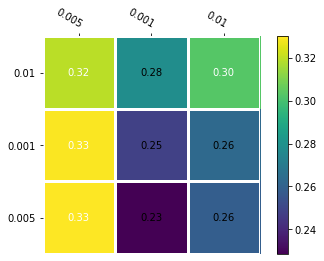

In [0]:
# By default, everything is loaded to cpu
 # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime


loss_c = []
loss_d0 = []
loss_d1 = []
loss_t = []

accuracies = []
accuracy_max=0
best_alpha = 0
best_lr = 0
max_max = 0
best_best = 0
alpha_alpha = 0
lr_lr = 0

#alphas = [0.1]
alphas = [0.005, 0.001, 0.01]
lrs = [0.01, 0.001, 0.005]
#lrs = [0.001]
accuracies = np.zeros((len(alphas), len(lrs)))

# It is possible to deativate domain adaptation or validation
da = True
validation = True

nan = False
i=0
len_dataloader = len(photo_dataset)

for alpha in alphas:
  j=0
  for lr in lrs:
    net = dann()
    net = net.to(DEVICE)
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    accuracy_max = 0
    current_step = 0
# Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}, ALPHA = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), alpha))
      m = 0
      iter_art_dataloader = iter(art_dataloader)
      # Iterate over the dataset
      for images, labels in photo_dataloader:
        
        #p = float(m + (epoch+1) * len_dataloader) / (NUM_EPOCHS+1) / len_dataloader
        #alpha = 2. / (1. + np.exp(-10 * p)) - 1
        #if current_step % LOG_FREQUENCY == 0:
         # print("Alpha "+str(alpha)+"\n")
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train() # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images, None)

        # Compute loss based on output and ground truth
        loss_classifier = criterion_classifier(outputs, labels)
        if not da:
          loss_classifier.backward()
          optimizer.step()
        else:
          loss_classifier.backward(retain_graph=True)
        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          loss_c.append(loss_classifier.item())
          print('Step {}, Loss Net {}'.format(current_step, loss_classifier.item()))
        if torch.isnan(loss_classifier):
          nan = True
          break
        # Compute gradients for each layer and update weights

        # Forward pass to the discriminator class label 0
        if not da:
          continue
        
        domain_labels = torch.zeros(BATCH_SIZE)
        domain_labels = domain_labels.long().to(DEVICE)

        outputs_domain = net(images, alpha=alpha)

        # Compute loss based on output and ground truth
        loss_discriminator0 = criterion_domain(outputs_domain, domain_labels)
        loss_discriminator0.backward(retain_graph=True)
        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          loss_d0.append(loss_discriminator0.item())
          print('Step {}, Loss Discriminator Class Label0 {}'.format(current_step, loss_discriminator0.item()))

        # Forward pass to the discriminator class label 1
        images, labels = next(iter_art_dataloader)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        domain_labels = torch.ones(BATCH_SIZE)
        domain_labels = domain_labels.long().to(DEVICE)

        outputs_dom = net(images, alpha=alpha)
        loss_discriminator1 = criterion_domain(outputs_dom, domain_labels)
        loss_discriminator1.backward()
        
        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          loss_d1.append(loss_discriminator1.item())
          print('Step {}, Loss Discriminator Class Label1 {}'.format(current_step, loss_discriminator1.item()))
        
        # if current_step % LOG_FREQUENCY == 0:
        #   loss_t.append(loss_tot)
        #   print('Step {}, Total Loss {}'.format(current_step, loss_tot.item()))
        

        optimizer.step() # update weights based on accumulated gradients

        current_step += 1
        m += 1
      
      if nan:
        break
      scheduler.step()

      if not validation:
        continue

      net.train(False) # Set Network to evaluation mode

      running_corrects = 0

      for images, labels in tqdm(skt_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        # Calculate Accuracy
      for images, labels in tqdm(car_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
      
      accuracy_val = running_corrects / float(len(skt_dataset)+len(car_dataset))

      print('\nValidation Accuracy on Sketch/Car: {}\n'.format(accuracy_val))
      if accuracy_val > accuracy_max:
        accuracy_max = accuracy_val
        best_model = copy.deepcopy(net)
        best_alpha = alpha
        best_lr = lr
      # Step the scheduler
      
      
    if accuracy_max > max_max:
      max_max = accuracy_max
      best_best = copy.deepcopy(best_model)
      alpha_alpha = best_alpha
      lr_lr = best_lr
    accuracies[i][j] = accuracy_max
    j+=1
  i+=1
  if not da:
    break 

im, cbar = heatmap(accuracies, alphas, lrs, cmap="RdYlGn")
annotate_heatmap(im)
plt.savefig("grid.png")
plt.show()
#files.download("grid.png")

plot_loss = False
if plot_loss:
  plt.figure()
  # naming the x axis 
  plt.xlabel('step') 
  # naming the y axis 
  plt.ylabel('loss_tot')
  step_values = range(0,len(loss_t)) 
  plt.xticks(step_values)
  plt.plot(step_values, loss_t, '--bo') 
  # giving a title to my graph 
  plt.title('Total Loss') 
  plt.savefig("loss_tot.png")
  plt.show()

  #files.download("loss_tot.png") 

  plt.figure()
  # naming the x axis 
  plt.xlabel('step') 
  # naming the y axis 
  plt.ylabel('') 
  plt.xticks(step_values)
  plt.plot(step_values, loss_c, '--bo') 
  # giving a title to my graph 
  plt.title('Classifier Loss') 
  plt.savefig("loss_c.png")
  plt.show()

  #files.download("loss_c.png") 

  plt.figure()
  # naming the x axis 
  plt.xlabel('step') 
  # naming the y axis 
  plt.ylabel('Discriminator Loss') 
  plt.xticks(step_values)
  plt.plot(step_values, loss_d0, '--bo', color='olive', label="d0")
  plt.plot(step_values, loss_d1, '--bo', color='skyblue', label="d1")
  plt.legend()

  # giving a title to my graph 
  plt.title('Discriminator Loss') 
  plt.savefig("loss_d.png")
  plt.show()

  #files.download("loss_d.png") 

**Test**

In [0]:
print("Test with best model with (apha, lr) ("+str(alpha_alpha) +","+str(lr_lr)+"): accuracy "+str(max_max))

net = best_best # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(art_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_dataloader)*BATCH_SIZE)
print(running_corrects)
print('Test Accuracy: {}'.format(accuracy))



  0%|          | 0/8 [00:00<?, ?it/s]

Test with best model with (apha, lr) (0.01,0.01): accuracy 0.3299856527977044




 12%|█▎        | 1/8 [00:04<00:28,  4.01s/it]

 25%|██▌       | 2/8 [00:04<00:17,  2.89s/it]

 38%|███▊      | 3/8 [00:04<00:10,  2.10s/it]

 50%|█████     | 4/8 [00:04<00:06,  1.56s/it]

 62%|██████▎   | 5/8 [00:07<00:05,  1.94s/it]

 75%|███████▌  | 6/8 [00:07<00:02,  1.42s/it]

 88%|████████▊ | 7/8 [00:08<00:01,  1.06s/it]

100%|██████████| 8/8 [00:08<00:00,  1.26it/s]



1069
Test Accuracy: 0.52197265625
